In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from augur.utils import json_to_tree
import json
import math

In [2]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Grabbing accumulated mutations for each variant

In [3]:
#grab lineage of leaf nodes
def find_lineage(tree, child_node, rows_for_tsv):
    gene_muts = {}
    node_path = tree.get_path(child_node)
    # do include child node in path
    i = len(node_path) - 1
    # add all mutations in path to list
    while (i >= 0):
        gene_muts = format_string(node_path[i].branch_attrs['mutations'],'nuc', gene_muts)
        i = i - 1
    #append variant name, mutation, and region to list
    for k in gene_muts.keys():
        for j in range(len(gene_muts[k])):
            temp_dict = gene_muts[k]
            mut =  str(temp_dict[j]) + '_' + str(k)
            rows_for_tsv.append({'variant': child_node.name, 'mutation': mut})

#put all the same gene mutations in the same list
def format_string(dict, key, gene_muts):
    for k in dict.keys():
        # exclude nucleotide mutations
        if (str(k) != key):
            if k not in gene_muts.keys():
                #make new dictionary for each region 
                gene_muts[k] = []
            for j in range(len(dict[k])):
                temp_dict = dict[k]
                #add list of mutations in this region to overall mutations dictionary
                gene_muts[k].append(temp_dict[j])
    return gene_muts

if __name__ == '__main__':
    #read in tree
    with open(f'../mutations-by-variant/pango_lineages.json', 'r') as f:
        tree_json = json.load(f)
    #put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    #create list of dictionaries for dataframe
    rows_for_tsv = []
    for tip in tree.find_clades(terminal=True):
        #append new row for every mutation in every child node
        find_lineage(tree, tip, rows_for_tsv)
    #make pandas dataframe from list of dicts
    accumulated_mutations = pd.DataFrame(rows_for_tsv)

In [4]:
#viewing accumulated mutations df
accumulated_mutations.to_csv("accumulated_mutations_output.tsv", sep="\t")
accumulated_mutations.head(10)

,variant,mutation
0,XA,L3S_E
1,XA,L6S_E
2,XA,I9T_E
3,XA,M11T_E
4,XA,F18L_E
5,XA,F19L_E
6,XA,F21L_E
7,XA,V22A_E
8,XA,I30T_E
9,XA,V32A_E


### Verifying that mutation counts match auspice json file

In [5]:
# check counts of mutations in the auspice tree to verify the mutations output
# creating mutation counts df
mutation_counts = {}
mutations = accumulated_mutations['mutation']
for m in mutations:
    if m in mutation_counts:
        mutation_counts[m] = mutation_counts[m] + 1
    else:
        mutation_counts[m] = 1
mut_counts = pd.DataFrame(mutation_counts.items(), columns=['Mutation', 'Count'])
mut_counts

,Mutation,Count
0,L3S_E,64
1,L6S_E,64
2,I9T_E,13
3,M11T_E,54
4,F18L_E,64
...,...,...
7540,A688T_S,1
7541,D144N_N,1
7542,A435S_S,1
7543,V116X_ORF8,2


# Assigning Mutational GAs to each variant

In [6]:
import jax.numpy as jnp
import numpy as np
import evofr as ef
from evofr.models.mutational_fitness_mlr import MutationalFitnessMLR, MutationalFitnessSequenceCounts

In [7]:
# Getting data
raw_seq = pd.read_csv("../../sars2-epistasis-modeling/count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
raw_seq_mut = raw_seq[~raw_seq.variant.str.startswith("X")]
raw_muts = accumulated_mutations
# exclude variants that are not present in mutations
raw_seq_mut =  raw_seq_mut[raw_seq_mut['variant'].isin(raw_muts.variant.values)]
variant_frequencies_mut = MutationalFitnessSequenceCounts(raw_seq_mut, raw_muts)

/home/allisonli/miniconda3/envs/nextstrain-workflow/lib/python3.9/site-packages/evofr/data/data_helpers.py:89: UserWarning: other not present in variant names. Using provided order.
  warnings.warn(


In [8]:
# Defining model
mlr = MutationalFitnessMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferMAP(iters=200_000, lr=4e-3)
posterior_mut = inference_method.fit(mlr, variant_frequencies_mut)
samples_mut = posterior_mut.samples

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
# defining the growth advantages
mut_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples_mut, posterior_mut.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [10]:
#viewing mutational ga df
mut_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,BA.1,50.7862,50.7862,50.7862
1,USA,BA.1.1,6.791757,6.791757,6.791757
2,USA,BA.1.1.1,1.3454388,1.3454388,1.3454388
3,USA,BA.1.1.10,8.016618,8.016618,8.016618
4,USA,BA.1.1.14,3.242204,3.242204,3.242204
...,...,...,...,...,...
171,USA,BQ.1.13,75.79984,75.79984,75.79984
172,USA,BQ.1.14,28.706526,28.706526,28.706526
173,USA,BQ.1.2,176.07335,176.07335,176.07335
174,USA,BQ.1.3,9.273813,9.273813,9.273813


In [11]:
mut_ga.sort_values('median_ga', ascending=False)

,location,variant,median_ga,ga_upper_80,ga_lower_80
154,USA,BF.7,316.61246,316.61246,316.61246
9,USA,BA.1.15.2,286.15204,286.15204,286.15204
173,USA,BQ.1.2,176.07335,176.07335,176.07335
78,USA,BA.5.1.18,92.231926,92.231926,92.231926
155,USA,BF.7.4,90.59033,90.59033,90.59033
...,...,...,...,...,...
54,USA,BA.2.75,0.0004526702,0.0004526702,0.0004526702
55,USA,BA.2.75.1,0.00034541302,0.00034541302,0.00034541302
57,USA,BA.2.75.5,8.585048e-05,8.585048e-05,8.585048e-05
162,USA,BM.1.1,2.5877048e-06,2.5877048e-06,2.5877048e-06


### Looking at Loss of Model 

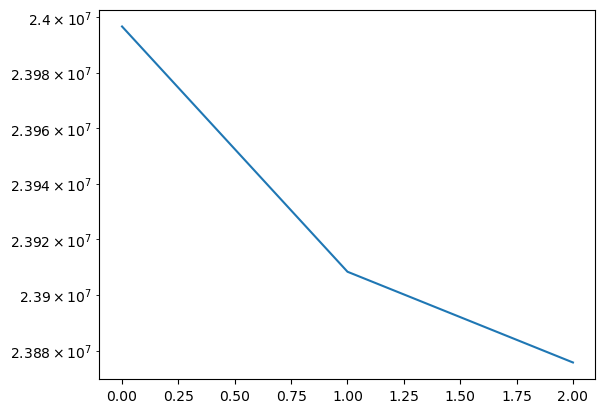

In [12]:
plt.plot(posterior_mut.samples['losses'])
plt.yscale("log")

In [13]:
posterior_mut.samples['losses']

Array([23996656., 23908384., 23875812., ...,       nan,       nan,
             nan], dtype=float32, weak_type=True)

### Looking at Presence of Mutations in Different Variants

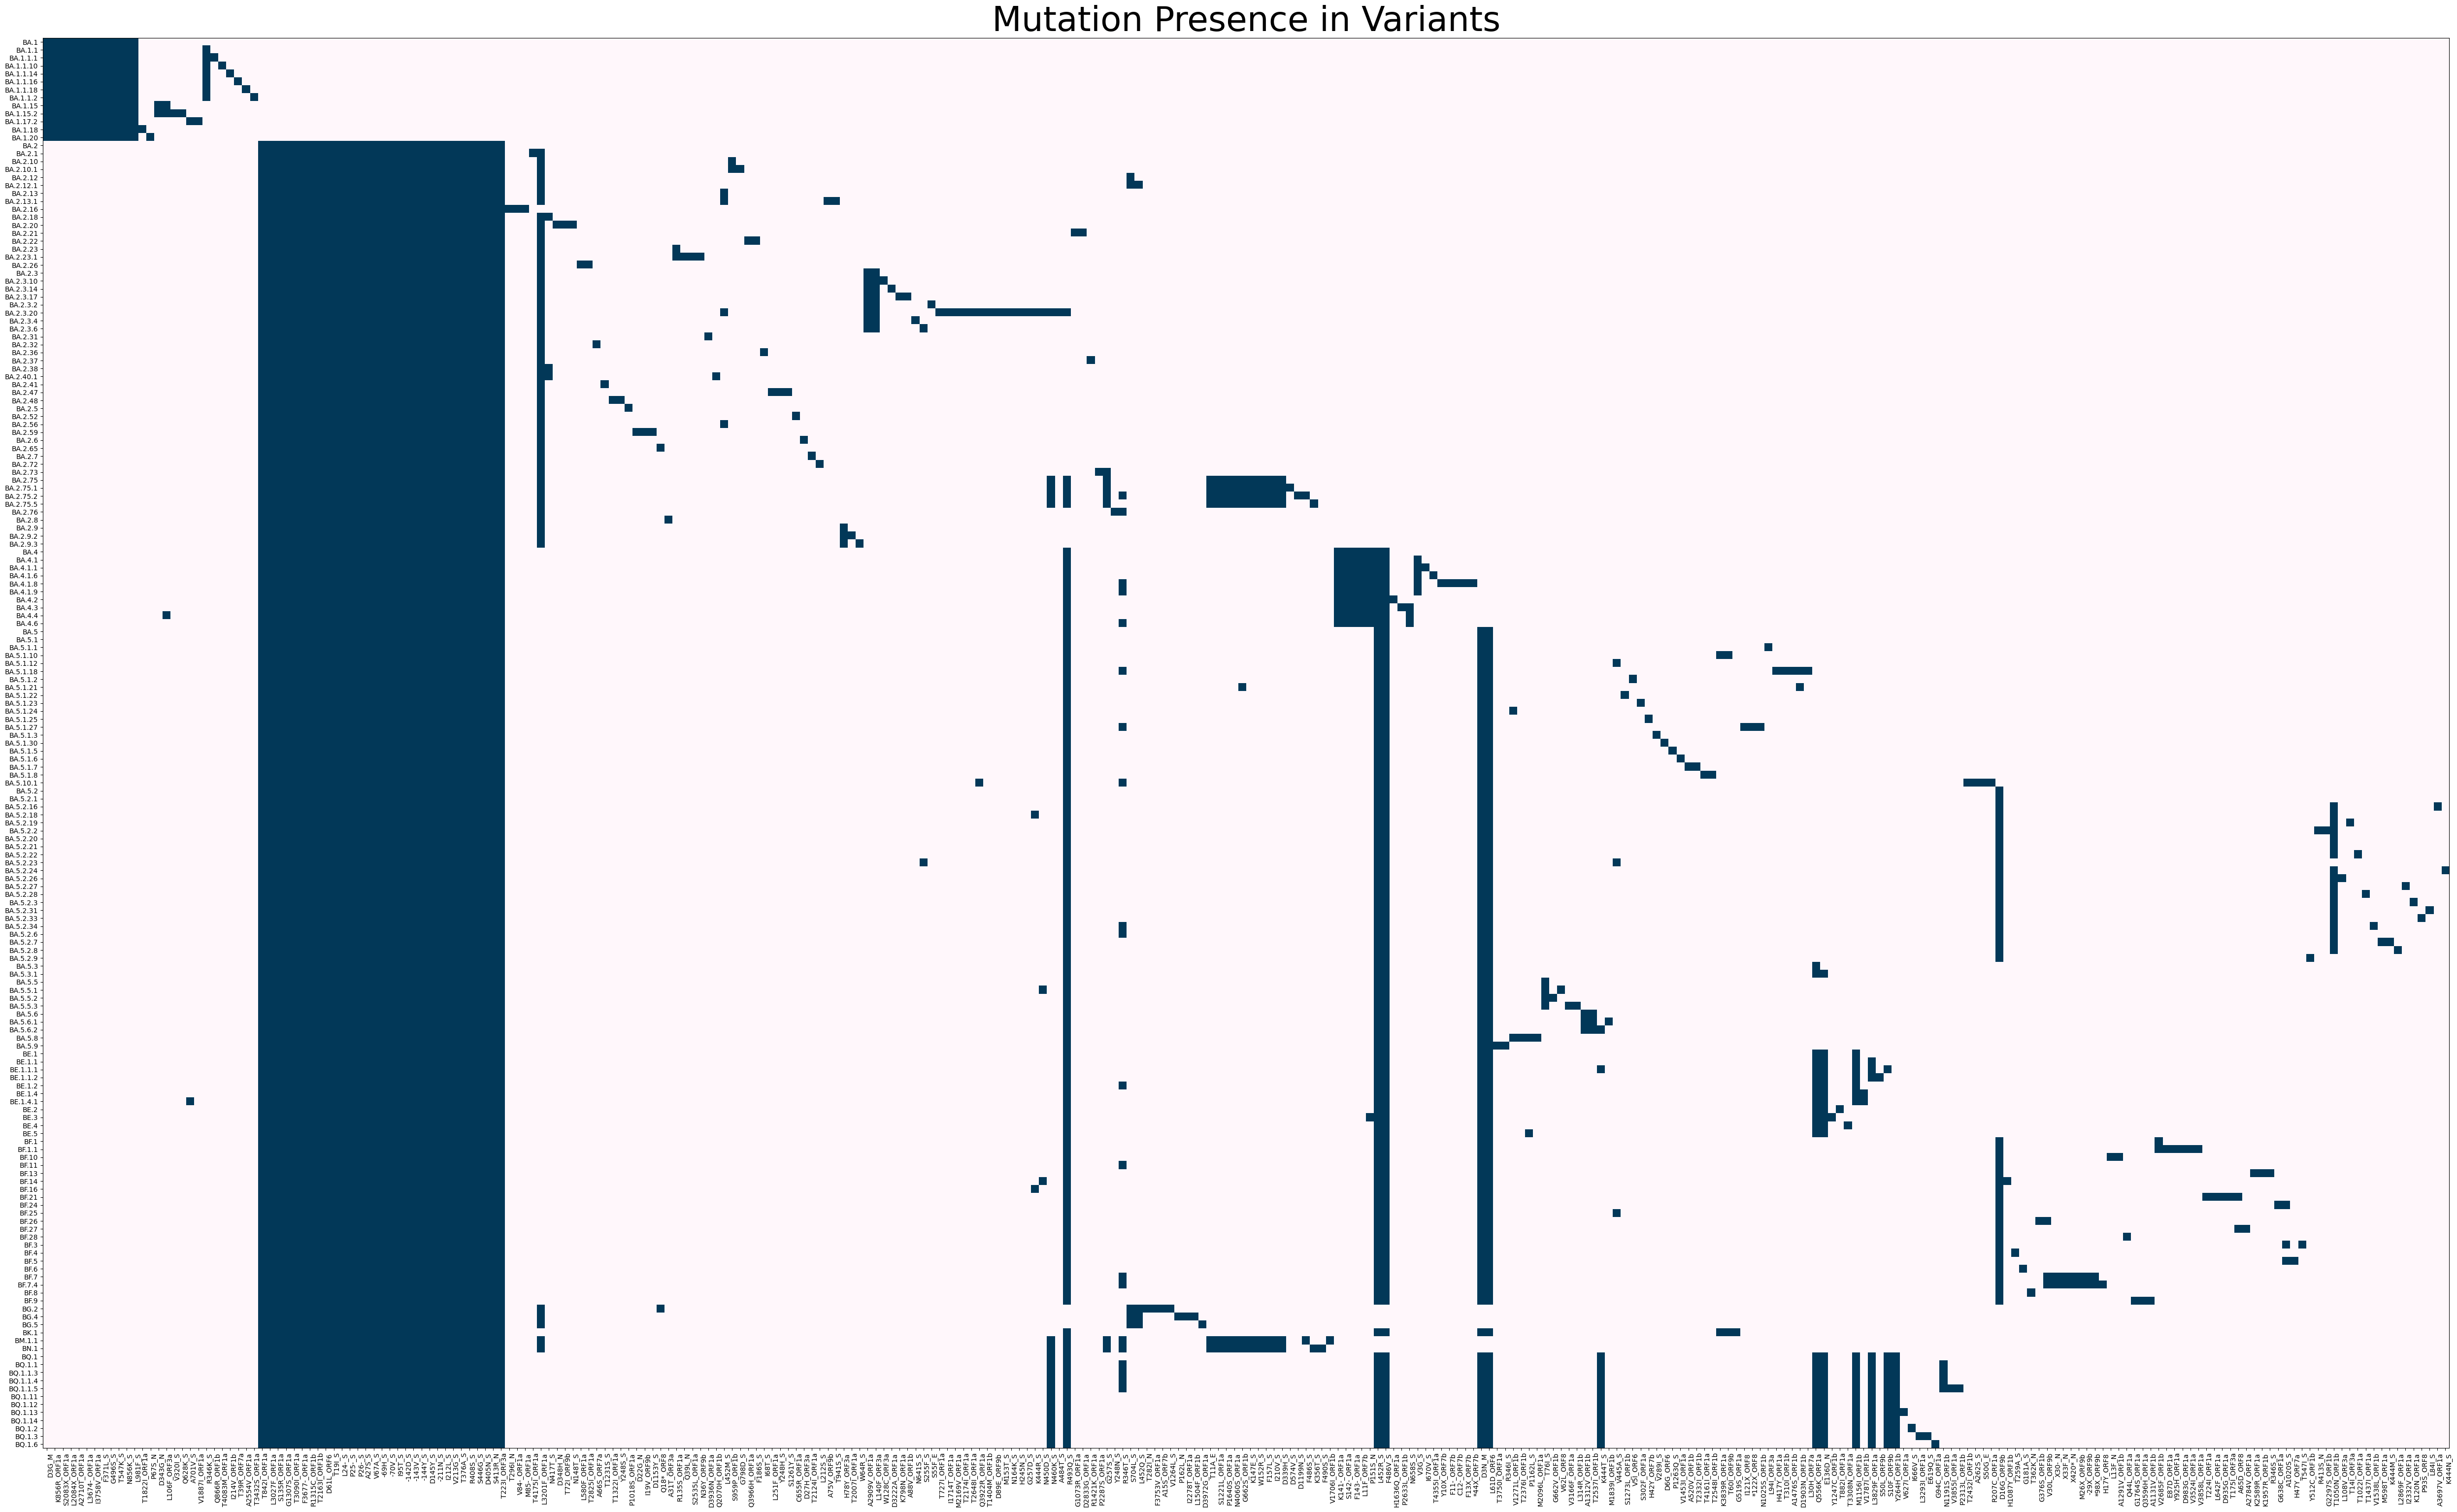

In [14]:
fig, ax = plt.subplots(figsize=(50,50))
im = ax.imshow(variant_frequencies_mut.mutation_presence, cmap="PuBu")
ax.set_yticks(np.arange(len(variant_frequencies_mut.var_names)), 
              labels=variant_frequencies_mut.var_names)
ax.set_xticks(np.arange(len(variant_frequencies_mut.mut_names)), 
              labels=variant_frequencies_mut.mut_names)
plt.setp(ax.get_xticklabels(),
         rotation = 90,
         ha = "right",
         rotation_mode = "anchor")
ax.set_title("Mutation Presence in Variants", 
             size=50)
fig.tight_layout()
plt.savefig("mutation_presence_heatmap.png",format='png',dpi=150)

# Assigning individual fitnesses to each mutation

In [15]:
# Grabbing fitness for each mutation, in sorted order
def mutations(samples, data):
    rows_for_tsv = []
    delta = jnp.median(samples["raw_delta"], axis=0)
    idx = (-delta).argsort()[:len(delta)]
    for i in idx:
        array = delta[i]
        rows_for_tsv.append({'mutation':data.mut_names[i], 'fitness_effect':array})
    return rows_for_tsv
table = mutations(samples_mut, variant_frequencies_mut)
mutations_table = pd.DataFrame(table)

In [16]:
# creating summary table with variant name, variant ga, mutation, mutation fitness
final_table = pd.merge(mut_ga, raw_muts, on="variant")
final_table = pd.merge(final_table, mutations_table, on="mutation")
final_table = final_table.drop(final_table.columns[0], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
# renaming the table
mutations_summary = final_table

In [17]:
# viewing table of mutation fitnesses
mutations_summary

,variant,median_ga,mutation,fitness_effect
0,BA.1,50.7862,D3G_M,0.49635786
1,BA.1.1,6.791757,D3G_M,0.49635786
2,BA.1.1.1,1.3454388,D3G_M,0.49635786
3,BA.1.1.10,8.016618,D3G_M,0.49635786
4,BA.1.1.14,3.242204,D3G_M,0.49635786
...,...,...,...,...
6437,BQ.1.13,75.79984,V627I_ORF1a,0.23118377
6438,BQ.1.2,176.07335,I666V_S,0.43185157
6439,BQ.1.3,9.273813,L3293I_ORF1a,-0.37058243
6440,BQ.1.3,9.273813,E619Q_S,0.101551555


# Assigning innovation GA to variants

In [18]:
# Getting data
raw_seq_innov = pd.read_csv("../count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies_innov = ef.InnovationSequenceCounts(raw_seq_innov, raw_variant_parents, pivot="BA.2")

In [19]:
# Defining model
mlr = ef.InnovationMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferMAP(iters=50_000, lr=4e-3)
# Fitting model
posterior_innov = inference_method.fit(mlr, variant_frequencies_innov)
samples_innov = posterior_innov.samples

In [20]:
innovation_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples_innov, posterior_innov.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [21]:
#viewing innovation ga df
innovation_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1.1.529,1.6081923,1.6081923,1.6081923
1,USA,BA.1,0.64846194,0.64846194,0.64846194
2,USA,BA.1.1,0.6741216,0.6741216,0.6741216
3,USA,BA.1.1.1,0.6722652,0.6722652,0.6722652
4,USA,BA.1.1.10,0.75387836,0.75387836,0.75387836
...,...,...,...,...,...
179,USA,XAZ,1.8961774,1.8961774,1.8961774
180,USA,XBB.1,2.58506,2.58506,2.58506
181,USA,XE,1.0579329,1.0579329,1.0579329
182,USA,XZ,1.1082662,1.1082662,1.1082662


# Comparing Innovation and Mutational Growth Advantages

In [22]:
# resolving weird formatting issues btwn csv and loading pandas df??
mut_ga.to_csv('mut_ga.tsv', sep="\t")
innovation_ga.to_csv('innov_ga.tsv', sep="\t")

In [23]:
# loading in datasets
parent_variant_relationships = pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t").set_index("variant")
mut_ga = pd.read_csv("mut_ga.tsv", sep="\t")
innovation_ga = pd.read_csv("innov_ga.tsv", sep="\t")

In [24]:
# Prep to merge
def clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships):
    innovation_ga = (innovation_ga
                     .rename(columns={"median_ga": "innov-ga"})
                     [["variant", "innov-ga"]])

    mut_ga = (mut_ga
              .rename(columns={"median_ga": "mut-ga"})
              [["variant", "mut-ga"]])

    ga_df = innovation_ga.merge(mut_ga, how="right").set_index("variant")
    ga_df["mut-ga"] = ga_df["mut-ga"] / ga_df.loc["BA.2.1"]["mut-ga"] # Scale GA by BA.2.1

    # Add parents
    def _get_parent(row):
        variant = row.name
        if variant in parent_variant_relationships.index:
            return parent_variant_relationships.loc[variant]
        return "NAN"

    ga_df["parent"] = ga_df.apply(_get_parent, axis=1)
    return ga_df

In [25]:
ga_df = clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships)

In [26]:
# Look for parent for mut-parent-ga
def add_deltas(row, prefix):
    # Give up if parent not found
    if row.parent not in ga_df.index:
        return pd.Series([np.nan, np.nan],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    # Get child growth advantage
    parent_row = ga_df.loc[row.parent]
    
    # Return parent ga and ratio
    return pd.Series([parent_row[prefix + "-ga"],  row[prefix + "-ga"] / parent_row[prefix + "-ga"]],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    
ga_df[["mut-parent-ga", "mut-pc-ratio"]] = ga_df.apply(add_deltas, prefix="mut", axis=1)
ga_df[["innov-parent-ga", "innov-pc-ratio"]] = ga_df.apply(add_deltas, prefix="innov", axis=1)

In [27]:
def is_outlier_IQR(data, col, scale=1.5):
    """
    Find wheter outliers in column col from dataframe data
    Uses IQR rule based on normal approximation.
    """

    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR
    return (data[col] < lower_bound) | (data[col] > upper_bound)

    
ga_df["innov-mut-ratio"] = ga_df["innov-ga"] / ga_df["mut-ga"]
ga_df["log-innov-mut-ratio"] = np.log(ga_df["innov-ga"] / ga_df["mut-ga"])
ga_df["outlier"] = is_outlier_IQR(ga_df, "log-innov-mut-ratio") # log-innov-mut-ratio ~ Normal()

In [28]:
# viewing ga_df
ga_df

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
BA.1,0.648462,257.576545,BA.2,NaN,NaN,NaN,NaN,0.002518,-5.984469,False
BA.1.1,0.674122,34.446312,BA.1,257.576545,0.133732,0.648462,1.039570,0.019570,-3.933747,False
BA.1.1.1,0.672265,6.823773,BA.1.1,34.446312,0.198099,0.674122,0.997246,0.098518,-2.317515,False
BA.1.1.10,0.753878,40.658540,BA.1.1,34.446312,1.180345,0.674122,1.118312,0.018542,-3.987733,False
BA.1.1.14,0.691037,16.443753,BA.1.1,34.446312,0.477373,0.674122,1.025092,0.042024,-3.169508,False
...,...,...,...,...,...,...,...,...,...,...
BQ.1.13,2.465841,384.440279,BQ.1,145.593248,2.640509,2.597910,0.949163,0.006414,-5.049256,False
BQ.1.14,2.559906,145.593248,BQ.1,145.593248,1.000000,2.597910,0.985371,0.017583,-4.040846,False
BQ.1.2,2.532489,893.005683,BQ.1,145.593248,6.133565,2.597910,0.974818,0.002836,-5.865390,False


## Plotting mutational ga vs. innovation ga

Each datapoint is a variant. Red datapoints are variants in which the rato between innovation/mutational ga is considered an outlier. Therefore, red variants might indicate epistasis where blue datapoint variants would indicate no epistasis. 

Text(0, 0.5, 'Mutation GA')

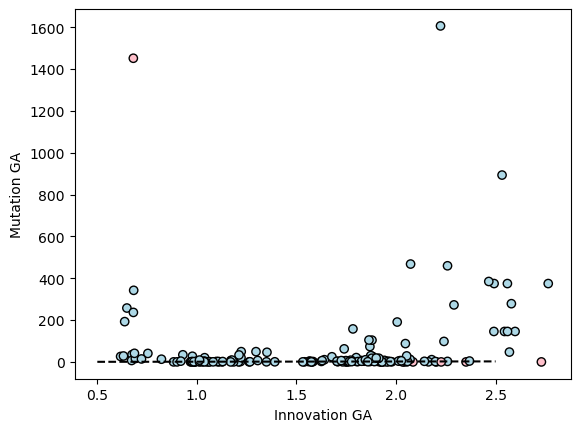

In [29]:
# Coloring by outlier
plt.scatter(ga_df["innov-ga"], ga_df["mut-ga"], 
            color=["pink" if value else "lightblue" for value in ga_df.outlier], 
            ec="k")
plt.plot([0.5, 2.5], [0.5, 2.5], color="k", linestyle="--")
plt.xlabel("Innovation GA")
plt.ylabel("Mutation GA")

# Looking at Outliers

In [30]:
# Defining outliers
outliers = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]

In [31]:
# Looking at outliers in bottom right with low ga
outliers

,innov-ga,mut-ga,parent,mut-parent-ga,mut-pc-ratio,innov-parent-ga,innov-pc-ratio,innov-mut-ratio,log-innov-mut-ratio,outlier
variant,,,,,,,,,,
BA.2.3.20,2.351756,0.007730,BA.2.3,0.282349,0.027376,0.989146,2.377561,304.256563,5.717871,True
BA.2.75.2,2.202258,0.000003,BA.2.75,0.002296,0.001476,2.041832,1.078570,649906.283090,13.384583,True
BA.2.75.5,2.085273,0.000435,BA.2.75,0.002296,0.189653,2.041832,1.021276,4789.162763,8.474111,True
BM.1.1,2.226847,0.000013,BA.2.75,0.002296,0.005717,2.041832,1.090612,169673.903893,12.041634,True


# Verifying Outlier Mutational GA Assignments

Given that:

    relative_fitness_variant = sum(mutational_fitness for mutation in variant)
    mutational_ga_variant = exp(relative_fitness_variant * generation_time)
    generation_time is fixed at 4.2

The calculated_ga variable for each variant is assigned using the equation above. 

In [32]:
# compiling outlier summary table with indv fitnesses and mutational ga
outlier_variants = ga_df[ga_df["outlier"]].index
outlier_variants = []
# just look at the outliers if there are any
# take the entire dataset if no outliers
if len(outlier_variants) < 1:
    outlier_variants = ga_df.index

# group by variants
grouped = mutations_summary.groupby('variant')
# final df
rows_for_tsv = []
for name, group in grouped:
    if name in outlier_variants:
        variant_dict = {}
        mutations = group['mutation']
        variant_dict['variant'] = name
        mut_ga = group['median_ga'].iloc[0]
        #mut_ga = ga_df
        variant_dict['mut_ga'] = mut_ga
        cum_sum = 0
        for m in mutations:
            # grabbing the fitness effect  of each mutation
            fitness_effect = group.loc[group['mutation'] == m, 'fitness_effect'].iloc[0]
            variant_dict[m] = fitness_effect
            # summing up all mutation fitnesses
            cum_sum += fitness_effect
        # multiply by generation time and raise e to this number
        calculated_ga = math.exp(cum_sum * 4.2)
        variant_dict['calculated_ga'] = calculated_ga
        variant_dict['match'] = (mut_ga == calculated_ga)
        rows_for_tsv.append(variant_dict)
resulting_table = pd.DataFrame(rows_for_tsv)      

In [33]:
#aesthetic changes to the summary df

# moving mut_ga to end 
cols_at_end = ['calculated_ga', 'mut_ga', 'match']
resulting_table = resulting_table[[c for c in resulting_table if c not in cols_at_end] 
        + [c for c in cols_at_end if c in resulting_table]]
# concatenating innovation ga column info 
if len(ga_df[ga_df["outlier"]].index) < 1:
    # take entire dataset if no outliers exist
    trimmed = ga_df.drop(columns=['mut-ga','parent','mut-parent-ga','mut-pc-ratio','innov-parent-ga','innov-pc-ratio','innov-mut-ratio','log-innov-mut-ratio','outlier'])
else:
    # just look at the outliers if there are any
    trimmed = ga_df[ga_df["outlier"]].drop(columns=['mut-ga','parent','mut-parent-ga','mut-pc-ratio','innov-parent-ga','innov-pc-ratio','innov-mut-ratio','log-innov-mut-ratio','outlier'])

merged = pd.merge(resulting_table, trimmed, on="variant", how="left")
resulting_table = merged

In [34]:
# viewing mutational fitnesses for outliers
resulting_table

,variant,D3G_M,K856R_ORF1a,S2083X_ORF1a,L2084X_ORF1a,A2710T_ORF1a,L3674-_ORF1a,I3758V_ORF1a,F371L_S,G496S_S,...,P2313L_ORF1b,V627I_ORF1a,I666V_S,L3293I_ORF1a,E619Q_S,G94C_ORF1a,calculated_ga,mut_ga,match,innov-ga
0,BA.1,0.49635786,0.25025433,-0.35857496,0.8186567,-0.06470669,-0.03814964,0.1757906,-0.012867758,-0.099380374,...,NaN,NaN,NaN,NaN,NaN,NaN,306.803432,50.7862,False,NaN
1,BA.1.1,0.49635786,0.25025433,-0.35857496,0.8186567,-0.06470669,-0.03814964,0.1757906,-0.012867758,-0.099380374,...,NaN,NaN,NaN,NaN,NaN,NaN,41.029530,6.791757,False,NaN
2,BA.1.1.1,0.49635786,0.25025433,-0.35857496,0.8186567,-0.06470669,-0.03814964,0.1757906,-0.012867758,-0.099380374,...,NaN,NaN,NaN,NaN,NaN,NaN,8.127898,1.3454388,False,NaN
3,BA.1.1.10,0.49635786,0.25025433,-0.35857496,0.8186567,-0.06470669,-0.03814964,0.1757906,-0.012867758,-0.099380374,...,NaN,NaN,NaN,NaN,NaN,NaN,48.429012,8.016618,False,NaN
4,BA.1.1.14,0.49635786,0.25025433,-0.35857496,0.8186567,-0.06470669,-0.03814964,0.1757906,-0.012867758,-0.099380374,...,NaN,NaN,NaN,NaN,NaN,NaN,19.586404,3.242204,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,BQ.1.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.23118377,NaN,NaN,NaN,NaN,457.912878,75.79984,False,NaN
172,BQ.1.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,173.418433,28.706526,False,NaN
173,BQ.1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.43185157,NaN,NaN,NaN,1063.673596,176.07335,False,NaN
174,BQ.1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.37058243,0.101551555,NaN,56.023841,9.273813,False,NaN


In [47]:
# filter table by highest GAs, find if there is any common mutations
resulting_table = resulting_table.sort_values('mut_ga', ascending=False)
top_10_gas = resulting_table.head(10)
pd.options.display.max_columns = None
top_10_gas

,variant,D3G_M,K856R_ORF1a,S2083X_ORF1a,L2084X_ORF1a,A2710T_ORF1a,L3674-_ORF1a,I3758V_ORF1a,F371L_S,G496S_S,T547K_S,N856K_S,L981F_S,R346K_S,Q866R_ORF1b,T4083M_ORF1a,I214V_ORF1b,T39R_ORF7a,A2554V_ORF1a,T3432S_ORF1a,D343G_N,L106F_ORF3a,V320I_S,Q628K_S,A701V_S,V1887I_ORF1a,T1822I_ORF1a,P67S_N,T4175I_ORF1a,L3201F_ORF1a,T842I_ORF1a,L3027F_ORF1a,S135R_ORF1a,G1307S_ORF1a,T3090I_ORF1a,F3677-_ORF1a,R1315C_ORF1b,T2163I_ORF1b,D61L_ORF6,T19I_S,L24-_S,P25-_S,P26-_S,A27S_S,V67A_S,-69H_S,-70V_S,I95T_S,-142D_S,-143V_S,-144Y_S,D145Y_S,-211N_S,I212L_S,V213G_S,T376A_S,R408S_S,S446G_S,D405N_S,S413R_N,T223I_ORF3a,S959P_ORF1b,G798D_S,S704L_S,L452Q_S,L452M_S,A75V_ORF9b,T941S_S,T296I_N,V84-_ORF1a,M85-_ORF1a,N417T_S,D348H_N,T72I_ORF9b,N148T_S,G1073R_ORF1a,D2833G_ORF1a,Q3966H_ORF1a,F186S_S,R135S_ORF1a,Q39L_N,S2535L_ORF1a,N36Y_ORF9b,L580F_ORF1a,T2825I_ORF1a,A2909V_ORF1a,L140F_ORF3a,W128C_ORF3a,D3222A_ORF1a,K798N_ORF1a,A88V_ORF1b,S55F_E,T727I_ORF1a,I1714T_ORF1a,M2169V_ORF1a,T2174I_ORF1a,T2648I_ORF1a,Q3922R_ORF1a,T1404M_ORF1b,D89E_ORF9b,M153T_S,N164K_S,H245N_S,G257D_S,K444R_S,N450D_S,N460K_S,A484T_S,R493Q_S,N641S_S,S255F_S,D3936N_ORF1a,A66S_ORF7a,I68T_S,R1421K_ORF1a,Q2070H_ORF1b,T1231S_S,L251F_ORF1a,Y248H_S,S1261Y_S,T1322I_ORF1a,Y248S_S,P1018S_ORF1a,C655R_ORF1a,D22G_N,I19V_ORF9b,D1153Y_S,D27H_ORF3a,Q18*_ORF8,T2124I_ORF1a,L212S_S,P2287S_ORF1a,G257S_S,T11A_E,S1221L_ORF1a,P1640S_ORF1a,N4060S_ORF1a,G662S_ORF1b,K147E_S,W152R_S,F157L_S,I210V_S,D339H_S,D574V_S,D1199N_S,F486S_S,R346T_S,K356T_S,Y248N_S,A31T_ORF3a,H78Y_ORF3a,T2007I_ORF1a,W64R_S,K141-_ORF1a,S142-_ORF1a,F143-_ORF1a,L11F_ORF7b,P151S_N,L452R_S,F486V_S,V3G_S,I670V_S,T4355I_ORF1a,Y10X_ORF7b,F11-_ORF7b,C12-_ORF7b,F13X_ORF7b,*44X_ORF7b,H1636Q_ORF1a,P2633L_ORF1b,N658S_S,D3N_M,L61D_ORF6,L94I_ORF3a,K3839R_ORF1a,T60I_ORF9b,V445A_S,H417Y_ORF1a,T310I_ORF1b,A1476S_ORF1b,D1903N_ORF1b,L30H_ORF7a,V5I_ORF6,S1273L_ORF1b,S302F_ORF1a,V1271L_ORF1b,H42Y_ORF7b,I121X_ORF8,*122X_ORF8,N1025S_ORF1b,V289I_S,D6G_ORF6,P1263Q_S,V1453I_ORF1a,A520V_ORF1b,T2332I_ORF1b,T4161I_ORF1a,T2548I_ORF1b,T2432I_ORF1b,A262S_S,S50G_E,R207C_ORF1a,D16G_ORF9b,A3697V_ORF1a,T1050N_ORF1b,T14I_ORF3a,R413S_N,G2297S_ORF1b,T1022I_ORF1a,K444N_S,L108V_ORF3a,I2332V_ORF1a,T1437I_ORF1a,K120N_ORF1a,L84I_S,P93S_ORF8,V1538L_ORF1b,M598T_ORF1a,K444M_S,L2869F_ORF1a,Y512C_ORF1b,Q556K_ORF1a,E136D_N,T76I_S,V62L_ORF8,G662V_ORF1b,V3166F_ORF1a,L314R_ORF1b,A1312V_ORF1b,T2537I_ORF1b,M1839I_ORF1b,K444T_S,T2376I_ORF1b,P1162L_S,M2096L_ORF1a,T3750I_ORF1a,R346I_S,M1156I_ORF1b,L3829F_ORF1a,S10F_ORF9b,S50L_ORF9b,V1787I_ORF1b,T882I_ORF1a,Y1247C_ORF1b,T3308N_ORF1a,V2685F_ORF1b,E87D_ORF1a,Y925H_ORF1a,D983G_ORF1a,V3524I_ORF1a,V3858L_ORF1a,L13F_N,A1291V_ORF1b,K2589R_ORF1a,K1957R_ORF1b,R346S_S,H1087Y_ORF1b,T224I_ORF1a,L642F_ORF1a,D935G_ORF1a,T175I_ORF3a,A65D_ORF8,G638C_ORF1a,A1020S_S,G376S_ORF1b,V30L_ORF9b,A2784V_ORF1a,Q44L_ORF1a,T547I_S,T259A_S,H47Y_ORF7a,G181A_S,X30-_N,X33F_N,X420*_N,M26X_ORF9b,-29X_ORF9b,*98X_ORF9b,H17Y_ORF8,T362K_N,G1764S_ORF1a,Q3596H_ORF1a,A1131V_ORF1b,T282I_N,F3753V_ORF1a,A15S_ORF7b,V1264L_S,P162L_N,I2278T_ORF1a,L1504F_ORF1b,D3972G_ORF1a,G519S_ORF1a,V1706I_ORF1b,F490S_S,Y264H_ORF1b,N1191S_ORF1b,V3855I_ORF1a,P2313L_ORF1b,V627I_ORF1a,I666V_S,L3293I_ORF1a,E619Q_S,G94C_ORF1a,calculated_ga,mut_ga,match,innov-ga
154,BF.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16025685,-0.22766188,-0.27777913,0.37861967,0.2659947,0.20626903,0.17679498,-0.35802948,-0.19610046,-0.33171532,-0.52692485,0.09922601,0.08489245,0.08881614,0.083073564,0.13172379,0.23922594,0.31479833,-0.011872332,0.25533655,-0.38700715,0.016328651,0.11083218,-0.6837365,-0.55290616,0.32120082,0.3088197,0.33346814,0.24030131,0.2818284,-0.11583987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.5392218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [48]:
# saving top mutational GA table to csv
top_10_gas.to_csv('top_assigned_gas.tsv', sep='\t')

In [44]:
top_10_gas = top_10_gas.drop(columns=['calculated_ga', 'innov-ga', 'match', 'mut_ga'])
variants = top_10_gas['variant']
mutations = list(top_10_gas[top_10_gas.columns.difference(['variant'])].columns)
presence = top_10_gas.drop(columns=['variant'])
presence = presence.fillna(0)
# presence = presence.astype(bool).astype(int)
presence = presence.values
presence = presence.tolist()
presence

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  Array(0.16025685, dtype=float32),
  Array(-0.22766188, dtype=float32),
  Array(-0.27777913, dtype=float32),
  Array(0.37861967, dtype=float32),
  Array(0.2659947, dtype=float32),
  Array(0.20626903, dtype=float32),
  Array(0.17679498, dtype=float32),
  Array(-0.35802948, dtype=float32),
  Array(-0.19610046, dtype=float32),
  Array(-0.33171532, dtype=float32),
  Array(-0.52692485, dtype=float32),
  Array(0.09922601, dtype=float32),
  Array(0.08489245, dtype=float32),
  Array(0.08881614, dtype=float32),
  Array(0.08307356, dtype=float32),
  Array(0.13172379, dtype=float32),
  Array(0.23922594, dtype=float32),
  Array(0.31479833, dtype=float32),
  Array(-0.01187233, dtype=float32),
  Array(0.25533655, dtype=float32),
  Array(-0.38700715, dtype=float32),
  Array(0.01632865, dtype=float32),
  Array(0.11083218, dtype=float32),
  Array(-0.6837365, 

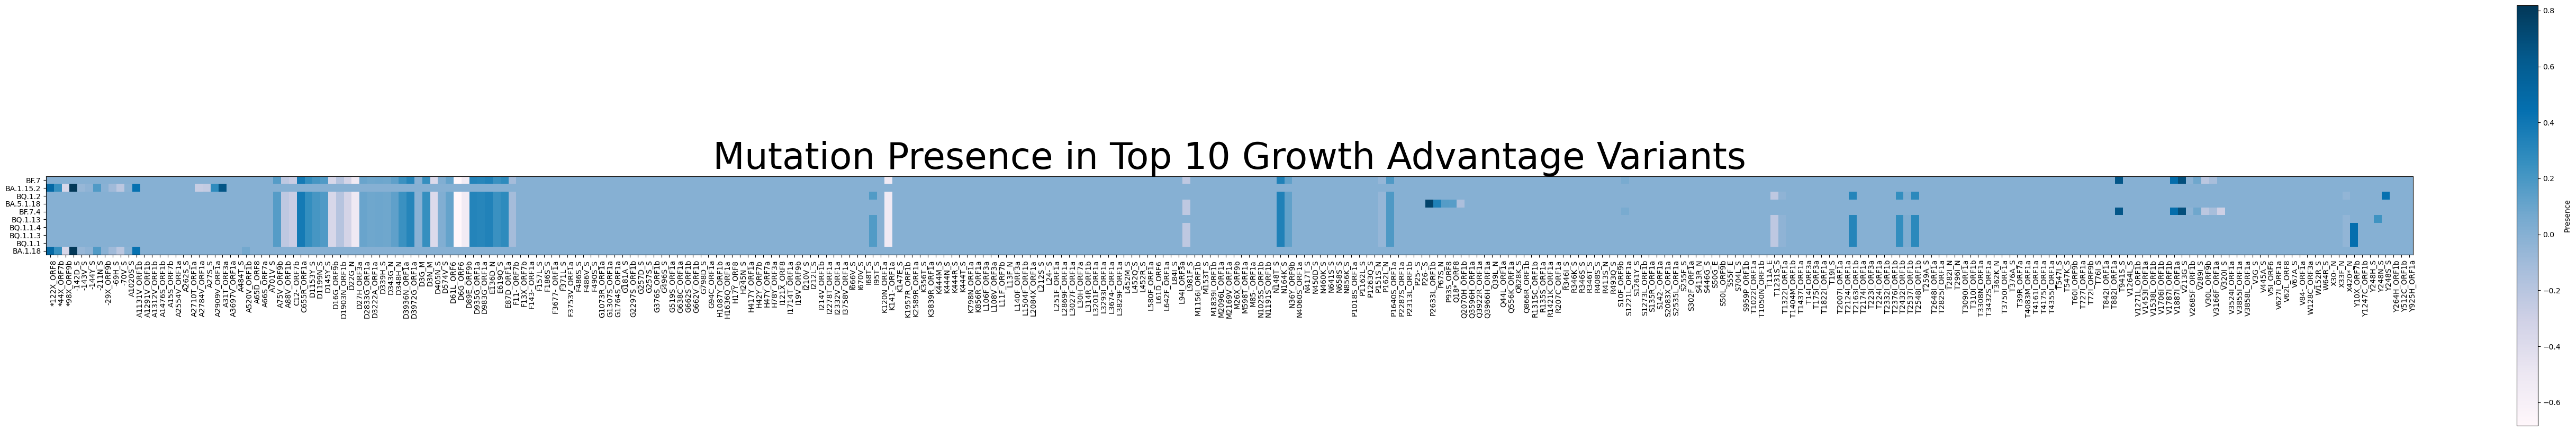

In [50]:
# heatmap of mutations in top 10 growth advantage variants
fig, ax = plt.subplots(figsize=(50,40))
im = ax.imshow(presence, cmap="PuBu")
ax.set_yticks(np.arange(len(variants)), 
              labels=variants)
ax.set_xticks(np.arange(len(mutations)), 
              labels=mutations)
plt.setp(ax.get_xticklabels(),
         rotation = 90,
         ha = "right",
         rotation_mode = "anchor")
ax.set_title("Mutation Presence in Top 10 Growth Advantage Variants", 
             size=50)
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04,  shrink=0.2)  
cbar.set_label("Presence")
fig.tight_layout()
plt.savefig("top_10_mutation_heatmap.png",format='png',dpi=150)

In [ ]:
# saving summary table to csv
resulting_table.to_csv('reformatted_table.tsv', sep='\t')